In [2]:
%matplotlib inline
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


# 差分隐私变体

```{admonition} 学习目标
阅读本章后，您将能够：
- 定义瑞丽差分隐私和零集中差分隐私
- 描述与$(\epsilon, \delta)$-差分隐私定义相比，这些差分隐私变体定义的优势
- 将这些变体的隐私消耗量转换为$(\epsilon, \delta)$-差分隐私的隐私消耗量
```

回想一下，我们前面讲解的大多数隐私消耗量计算方法所得到的都是隐私消耗量的*上*界。有时，我们计算得到的都是非常宽松的上界，而真正的隐私消耗量远低于计算得到的上界。提出差分隐私新变体的主要目的就是能得到更加紧致的隐私消耗量（这对于迭代算法非常重要），且相应的隐私定义在实际中仍然可用。例如，$(\epsilon, \delta)$-差分隐私的灾难性失败情况就不是我们想要的隐私保护效果。我们在本节中介绍的差分隐私变体可以为某些类型的问询提供更加紧致的隐私消耗量组合结果，同时*消除*灾难性失败情况。

快速回忆一下我们已经介绍过的工具。我们首先来看$\epsilon$-差分隐私的串行组合性。可以证明$\epsilon$-差分隐私的串行组合性是*紧致的*。这是什么意思呢？意思是对于任何小于串行组合性得到的隐私消耗量下界，我们都可以找到不满足此下界的反例：

- 存在满足$\epsilon$-差分隐私的机制$F$
- 当组合$k$次时，$F$满足$k\epsilon$-差分隐私
- 但对任意$c < k$，$F$不满足$c\epsilon$-差分隐私

我们通过图像直观感受一下上述结论。我们把问询"向量化"，看看隐私消耗量会发生什么变化。我们将多个问询合并为一个问询，此问询返回包含多个回复的向量。因为回复值是一个向量，我们可以使用一次向量值拉普拉斯机制，从而避免使用组合定理。接下来，我们分别为串行组合性和"向量"形式画出$k$次问询所需的噪声量。在串行组合性中，每个问询的敏感度是1，因此每个问询的噪声尺度为$\frac{1}{\epsilon_i}$。如果我们想让总隐私消耗量等于$\epsilon$，则$\epsilon_i$的求和结果应等于$\epsilon$，因此$\epsilon_i = \frac{\epsilon}{k}$。这意味着每个问询需要尺度为$\frac{k}{\epsilon}$的拉普拉斯噪声。"向量化"形式只包含一次问询，但此问询的$L1$敏感度为$\sum_{i=1}^k 1 = k$。因此，向量化形式的噪声尺度同样为$\frac{k}{\epsilon}$。

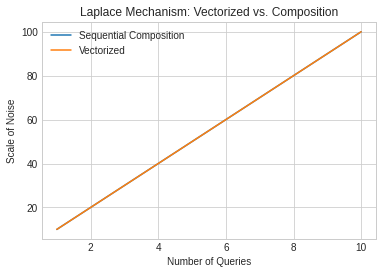

In [12]:
ks = np.linspace(1, 10, 20)
epsilon = .1

# 每个问询的L1敏感度：1
# 每个问询的噪声尺度：1/ε
# 问询次数：k
noises_seq = [k*(1/epsilon) for k in ks]
plt.plot(ks, noises_seq, label='串行组合性')

# 问询次数：1
# 每个问询的L1敏感度：k
# 每个问询的噪声尺度：k/ε
noises_l1 = [1*(k/epsilon) for k in ks]
plt.plot(ks, noises_l1, label='向量化')
plt.title('拉普拉斯机制：向量化 vs. 组合性')
plt.xlabel('问询数量')
plt.ylabel('噪声尺度')
plt.legend();

两条线*完全*重合。这意味着我们无论执行多少次问询，只要要求问询满足$\epsilon$-差分隐私，我们就不可能得到比串行组合性更好的组合方法。这是因为串行组合性与向量化问询的结果一致，而向量化问询是单次的，不涉及问询的组合，因此串行组合性得到的隐私消耗量已经是最优的了。

那$(\epsilon, \delta)$-差分隐私呢？情况有所不同。我们可以在串行组合下使用高级组合性。这里我们必须非常小心，保证总隐私消耗量确实为$(\epsilon, \delta)$。特别地，我们设置$\epsilon_i = \frac{\epsilon}{2 \sqrt{2k \log(1/\delta')}}$，$\delta_i = \frac{\delta}{2k}$，以及$\delta' = \frac{\delta}{2}$（将$\delta$拆分成两部分，50%用于问询，50%用于高级组合）。利用高级组合性，所有$k$次问询的总隐私消耗量为$(\epsilon, \delta)$。使用高斯机制的噪声尺度为：

\begin{align}
\sigma^2 =& \frac{2 \log\left(\frac{1.25}{\delta_i}\right)}{\epsilon_i^2}\\
 =& \frac{16 k \log\left(\frac{1}{\delta'}\right) \log\left(\frac{1.25}{\delta_i}\right)}{\epsilon^2}\\
 =& \frac{16 k \log\left(\frac{2}{\delta}\right) \log\left(\frac{2.5 k}{\delta}\right)}{\epsilon^2}\\
\end{align}

在"向量化"形式下，我们只需要一次问询，其$L2$敏感度为$\sqrt{k}$。使用高斯机制的噪声尺度为$\sigma^2 = \frac{2 k \log(1.25/\delta)}{\epsilon^2}$。

在实际应用中，两个噪声尺度表达式的差异意味着什么呢？随着$k$的增大，两个表达式的渐进变化趋势相同，但常数项有所不同。与此同时，应用高级组合性得到的表达式中，$\delta$包含额外的对数因子。在这些因素的作用下，应用高级组合性得到的隐私消耗量边界要比实际情况宽松得多。我们同样把两个噪声尺度表达式的图像画出来。

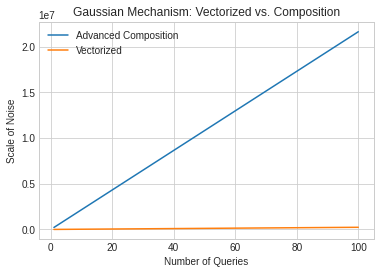

In [14]:
ks = np.linspace(1, 100, 20)
epsilon = .1
delta = 1e-5

# 每个问询的L2敏感度：1
# 问询次数：k
noises_seq = [16*k*np.log(1.25/delta)*np.log(1/delta)/(epsilon**2) for k in ks]
plt.plot(ks, noises_seq, label='高级组合性')

# 问询次数：1
# 每个问询的L2敏感度：sqrt(k)
noises_l1 = [2*k*np.log(1.25/delta)/(epsilon**2) for k in ks]
plt.title('高斯机制：向量化 vs. 组合性')
plt.xlabel('问询次数')
plt.ylabel('噪声尺度')
plt.plot(ks, noises_l1, label='向量化')
plt.legend();

两者的图像甚至相距甚远，"向量化"的噪声尺度增长量*远*比高级组合性慢。这意味着什么呢？我们应该能在串行组合方面做得*更*好！

## 最大散度和瑞丽散度

可以证明，可以直接应用*最大散度*（Max Divergence）来描述差分隐私的定义。在统计学中，[*散度*](https://en.wikipedia.org/wiki/Divergence_(statistics))（Divergence）是一种度量两种概率分布差异的方法，而这正是差分隐私定义的基本思想。*最大散度*是[KL散度](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)（Kullback–Leibler Divergence）的最坏情况，也是度量概率分布差异最常见的方法之一。两个概率分布$Y$和$Z$的最大散度定义为：

\begin{align}
D_\infty(Y \Vert Z) = \max_{S \subseteq \text{Supp}(Y)} \Big[\log \frac{Pr[Y \in S]}{Pr[Z \in S]} \Big]
\end{align}

此定义从形式上看已经很像$\epsilon$-差分隐私的定义了！特别地，可以证明如果：

\begin{align}
D_\infty(F(x) \Vert F(x') \leq \epsilon
\end{align}

则$F$满足$\epsilon$-差分隐私。

差分隐私的一个有趣研究方向是尝试引入不同类型的散度来构建变种隐私定义。在已有的散度定义中，[瑞丽散度](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy#R%C3%A9nyi_divergence)（Rényi Divergence）尤其有趣，因为我们也可以（像最大散度一样）从瑞丽散度中恢复出差分隐私的原始定义。概率分布$P$和$Q$的$\alpha$阶瑞丽散度定义为：

\begin{align}
D_\alpha(P \Vert Q) = \frac{1}{\alpha - 1} \log E_{x \sim Q} \Big(\frac{P(x)}{Q(x)}\Big)^\alpha
\end{align}

其中$P(x)$和$Q(x)$分别为$P$和$Q$在点$x$处的概率密度。

如果我们令$\alpha = \infty$，则我们可以立即恢复出$\epsilon$-差分隐私的定义！我们会自然而然地想到这样一个问题：如果我们把$\alpha$设置为别的数会发生什么？我们接下来将看到，使用瑞丽散度可以得到有趣的宽松差分隐私定义，这些定义对于组合定理更加友好，同时可以避免像$(\epsilon, \delta)$-差分隐私定义那样出现灾难性失败的可能。

## 瑞丽差分隐私

2017年，Ilya Mironov提出[瑞丽差分隐私](https://arxiv.org/abs/1702.07476)（Rényi Differential Privacy，RDP） {cite}`mironov2017renyi`。如果对与所有的临近数据集$x$和$x'$，随机机制$F$满足

\begin{align}
D_\alpha(F(x) \Vert F(x')) \leq \bar{\epsilon}
\end{align}

则称此机制$F$满足$(\alpha, \bar{\epsilon})$-RDP。

换句话说，瑞丽差分隐私要求$F(x)$和$F(x')$的$\alpha$阶瑞丽散度不超过$\bar{\epsilon}$。请注意，我们将使用$\bar{\epsilon}$表示瑞丽差分隐私的参数$\epsilon$，以区分$\epsilon$-差分隐私和$(\epsilon, \delta)$-差分隐私中的$\epsilon$。

瑞丽差分隐私的一个关键性质是，如果一个机制满足瑞丽差分隐私，那么此机制也满足$(\epsilon, \delta)$-差分隐私。具体而言，如果$F$满足$(\alpha, \bar{\epsilon})$-瑞丽差分隐私，那么对于任意给定的$\delta > 0$，$F$满足$(\epsilon, \delta)$-差分隐私，其中$\epsilon = \bar{\epsilon} + \frac{\log(1/\delta)}{\alpha - 1}$。分析者可以自由选择$\delta$的取值。实际应用中应该选择一个有意义的$\delta$值（如令$\delta \leq \frac{1}{n^2}$）。

实现瑞丽差分隐私的基本机制是高斯机制。具体来说，对于一个$L2$敏感度为$\Delta f$的函数$f : \mathcal{D} \rightarrow \mathbb{R}^k$，可以按照下述方法构造$(\alpha, \bar{\epsilon})$-瑞丽差分隐私机制：

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2) \text{ where } \sigma^2 = \frac{\Delta f^2 \alpha}{2\bar{\epsilon}}
\end{align}

我们按照如下方法实现满足瑞丽差分隐私的高斯机制：

In [1]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon_bar):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon_bar))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

瑞丽差分隐私的主要优势是，用高斯机制实现的瑞丽差分隐私满足*紧致组合*性。同时，组合使用机制时不需要引入特殊的高级组合定理。瑞丽差分隐私的串行组合性为：

- 如果$F_1$满足$(\alpha, \bar{\epsilon_1})$-瑞丽差分隐私
- 且$F_2$也满足$(\alpha, \bar{\epsilon_2})$-瑞丽差分隐私
- 则他们的组合机制满足$(\alpha, \bar{\epsilon_1} + \bar{\epsilon_2})$-瑞丽差分隐私

基于上述串行组合性描述，组合使用$k$次$(\alpha, \bar{\epsilon})$-瑞丽差分隐私机制所得到的机制满足$(\alpha, k\bar{\epsilon})$-瑞丽差分隐私。当给定噪声等级时（即给定$\sigma^2$的值时），使用瑞丽差分隐私的串行组合性来限制重复应用高斯机制的隐私消耗量，再将隐私定义转换为$(\epsilon, \delta)$-差分隐私，这一过程计算得到的总隐私消耗量通常比直接在$(\epsilon, \delta)$中应用串行组合定理（甚至使用高级组合定理）得到的总隐私消耗量要低得多。

因此，瑞丽差分隐私的基本思想已被广泛应用于近期提出的迭代算法中，大大改善隐私消耗量的计算结果。谷歌的[差分隐私Tensorflow](https://github.com/tensorflow/privacy)就使用了瑞丽差分隐私的基本思想。

最后，与其他差分隐私变体一样，瑞丽差分隐私也满足后处理性。

## 零集中差分隐私

Mark Bun和Thomas Steinke也考虑到了类似的问题。他们于2016年提出了[零集中差分隐私](https://arxiv.org/abs/1605.02065)（Zero-concentrated Differential Privacy，zCDP） {cite}`bun2016concentrated`。与瑞丽差分隐私相同，零集中差分隐私也是根据瑞丽散度定义的差分隐私变体。不过，零集中差分隐私定义只包含了一个隐私参数（$\rho$）。如果对于所有的临近数据集$x$和$x'$，以及所有的$\alpha \in (1, \infty)$，如果一个随机机制$F$满足：

\begin{align}
D_\alpha (F(x) \Vert F(x')) \leq \rho\alpha
\end{align}

则称此$F$满足$\rho$-零集中差分隐私。

零集中差分隐私的定义比瑞丽差分隐私更强，因为零集中差分隐私对瑞丽散度的阶提出了更严格的限制。不过，随着$\alpha$的增大，限制会变得更加宽松。与瑞丽差分隐私相同，也可以把零集中差分隐私转换为$(\epsilon, \delta)$-差分隐私：如果$F$满足$\rho$-零集中差分隐私，则对于任意给定的$\delta > 0$，$F$满足$(\epsilon, \delta)$-差分隐私，其中$\epsilon = \rho + 2\sqrt{\rho \log(1/\delta)}$。

零集中差分隐私和瑞丽差分隐私的另一个相似点在于，也可以使用高斯机制实现零集中差分隐私。具体而言，对于一个$L2$敏感度为$\Delta f$的函数$f : \mathcal{D} \rightarrow \mathbb{R}^k$，下述机制满足$\rho$-零集中差分隐私：

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2) \text{ 其中 } \sigma^2 = \frac{\Delta f^2}{2\rho}
\end{align}

与瑞丽差分隐私一样，很容易实现零集中差分隐私机制：

In [3]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

零集中差分隐私和瑞丽差分隐私还有一个相似点：当重复使用高斯机制实现零集中差分隐私时，应用串行组合性得到的隐私消耗量也是渐进紧致的。零集中差分隐私的串行组合性描述也非常简单：把各个$\rho$相加即可。具体而言：


串行组合：
- 如果$F_1$满足$\rho_1$-零集中差分隐私
- 且$F_2$满足$\rho_2$-零集中差分隐私
- 则他们的组合机制满足$\rho_1+\rho_2$-零集中差分隐私。

最后，零集中差分隐私同样满足后处理性。

## 不同差分隐私变体的组合性

我们何时需要使用差分隐私变体？我们又应该使用哪个差分隐私变体呢？

当遇到下述情况时，近年来提出的差分隐私变体将*显著*收紧隐私消耗量的边界：

- 使用高斯机制实现差分隐私（特别是高维向量）
- 问询算法多次（如成百上千次）使用差分隐私机制

我们该如何使用瑞丽差分隐私和零集中差分隐私呢？通常，我们先选择好差分隐私变体，并应用此变体实现差分隐私算法。随后，我们计算总隐私消耗量，并将计算结果转换回$(\epsilon, \delta)$-差分隐私，以便与其他算法进行比较。

我们用一个例子来展示使用瑞丽差分隐私和零集中差分隐私的效果。想象一个应用$k$次高斯机制的问询算法。我们固定$\sigma$（即固定$k$轮迭代中每轮高斯机制引入的噪声量）和$\delta$的取值，比较每个变体最终组合得到的总隐私消耗量$\epsilon$。

可以看到，虽然增加了相同的噪声量，但瑞丽差分隐私和零集中差分隐私的串行组合会得到*更小的$\epsilon$*。由于所有变体都应用了相同的实现机制（即每种情况下增加的噪声类型和噪声量都相同），这意味着瑞丽差分隐私和零集中差分隐私为同一算法提供了*更加紧致的隐私消耗量上界*。

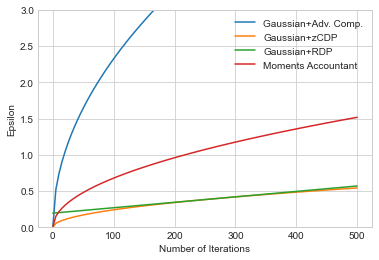

In [13]:
sigma = 200.0
delta = 1e-5
lap_eps = 2*sigma**2
xs = np.linspace(0, 500, 100)

gauss_eps = np.sqrt(2 * np.log(1.25/delta) / sigma**2)
ys_gauss = [x * np.sqrt(2 * np.log(1.25/delta) / sigma**2) for x in xs]

ys_gauss_adv = [2 * gauss_eps * np.sqrt(2 * x * np.log(1/delta)) for x in xs]

rho = 1/(2*sigma**2)
ys_gauss_zcdp = [(x*rho) + 2*np.sqrt((x*rho) * np.log(1/delta)) for x in xs]

alpha = 60
rdp_eps = alpha / (2*sigma**2)

ys_gauss_rdp = [(x*rdp_eps) + np.log(1/delta)/(alpha-1) for x in xs]

# ys_moments = [4*np.sqrt(x*np.log(1/delta))/sigma for x in xs]

plt.plot(xs, ys_gauss_adv, label="高斯机制+高级组合性")
plt.plot(xs, ys_gauss_zcdp, label="高斯机制+零集中差分隐私")
plt.plot(xs, ys_gauss_rdp, label="高斯机制+瑞丽差分隐私")
# plt.plot(xs, ys_moments, label="Moments Accountant")

plt.xlabel('迭代轮数')
plt.ylabel('ε')
plt.ylim(0, 3.0)


plt.legend()
plt.show();

首先要注意的是，无论应用零集中差分隐私还是瑞丽差分隐私，其串行组合性都比应用高级组合性的$(\epsilon, \delta)$-差分隐私所得到的总隐私消耗量要好得多。当使用高斯机制来构造迭代算法时，应该优先考虑使用这些差分隐私变体。

其次要注意的是零集中差分隐私（橘色曲线）和瑞丽差分隐私（绿色曲线）之间的区别。由于瑞丽差分隐私固定了$\alpha$，瑞丽差分隐私的$\epsilon$会随$k$值的增长而线性增长。与之相比，零集中差分隐私会同时考虑多个$\alpha$，因此零集中差分隐私的$\epsilon$会随$k$值的增长而次线性增长。两条曲线在某些$k$下会相交，相交点由瑞丽差分隐私选择的$\alpha$决定（当$\alpha = 20$时，两条曲线大概在$k=300$时相交）。

该差异的实际影响在于，使用瑞丽差分隐私时必须慎重选择$\alpha$的取值，以得到尽可能紧致的隐私消耗量。通常很容易做到这一点，因为算法本身一般也需要以$\alpha$作为输入参数，因此我们可以简单地测试多个$\alpha$的取值，观察哪个值得到的隐私消耗量$\epsilon$最小。因为该测试与数据*无关*（仅与我们选择的隐私参数和迭代次数有关），我们可以根据需要测试任意数量的$\alpha$，这不会增加额外的隐私消耗量。我们只需要测试少量的$\alpha$（一般可以令$\alpha$从2取到100）即可找到最小值。实际应用中大多都会使用此方法。谷歌的差分隐私Tensorflow就是使用此方法来得到适当的$\alpha$。